---
---
#                                      Breast Cancer Classification
---
---

## Attribute Information:

-  ID number 
- Diagnosis (M = malignant, B = benign)
- M is converted into 1, B is converted into 0


## Features that are computed for each cell nucleus:

- radius (mean of distances from center to points on the perimeter)
- texture (standard deviation of gray-scale values)
- perimeter
- area
- smoothness (local variation in radius lengths)
- compactness (perimeter^2 / area - 1.0)
- concavity (severity of concave portions of the contour)
- concave points (number of concave portions of the contour)
- symmetry
- fractal dimension ("coastline approximation" - 1)

##  Importing libraries

In [94]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import log_loss, recall_score

warnings.filterwarnings('ignore')


## **Load data**

In [40]:
df = pd.read_csv('data.csv')

In [41]:
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


## **Data Preprocessing**

In [42]:
df.drop(['id', 'Unnamed: 32'], axis = 1, inplace = True)

In [43]:
df.diagnosis.unique()

array(['M', 'B'], dtype=object)

In [44]:
df['diagnosis'] = df['diagnosis'].apply(lambda val: 1 if val == 'M' else 0)

## **EDA**

In [46]:
df.describe()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    int64  
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

In [93]:
# Define a Z-score threshold for identifying outliers (e.g., Z-score > 3 or < -3)
z_score_threshold = 3
# Find outliers using Z-scores for each column
outliers_per_column = {col: df[col][np.abs(stats.zscore(df[col])) > z_score_threshold] for col in df.columns}
# Print outliers for each column
for col, outliers in outliers_per_column.items():
    if not outliers.empty:
        print(f"Outliers in '{col}':\n{outliers}",end=",")

Outliers in 'concave points_mean':
41     0.182300
122    0.187800
206    0.191300
218    0.201200
469    0.195322
Name: concave points_mean, dtype: float64,Outliers in 'radius_worst':
122    33.12
206    33.13
381    36.04
Name: radius_worst, dtype: float64,Outliers in 'perimeter_worst':
122    220.8
206    229.3
381    251.2
Name: perimeter_worst, dtype: float64,Outliers in 'area_worst':
122    3216.000000
206    3234.000000
226    3143.000000
374    2944.000000
381    4254.000000
410    2906.000000
476    3169.094724
495    3028.027921
496    2944.209445
Name: area_worst, dtype: float64,

In [92]:
import pandas as pd
from scipy import stats
z_score_threshold = 3
# Function to find percentage of outliers using Z-scores for each column
percentage_outliers_per_column = {col: (sum(np.abs(stats.zscore(df[col])) > z_score_threshold) / len(df[col])) * 100 for col in df.columns}
# Print the percentage of outliers for each column
for col, percentage in percentage_outliers_per_column.items():
    print(f"Percentage of outliers in '{col}': {percentage:.2f}%",end=",")


Percentage of outliers in 'concave points_mean': 0.87%,Percentage of outliers in 'radius_worst': 0.52%,Percentage of outliers in 'perimeter_worst': 0.52%,Percentage of outliers in 'area_worst': 1.57%,Percentage of outliers in 'concave points_worst': 0.00%,Percentage of outliers in 'diagnosis': 0.00%,

In [50]:
df['diagnosis'].value_counts()/len(df['diagnosis'])*100

0    62.741652
1    37.258348
Name: diagnosis, dtype: float64

#### There are no missing values in the data. The Data has more number of benign case data.   But, the data is imbalance data

## Exploratory Data Analysis (EDA)

In [51]:
col=list(df.columns)

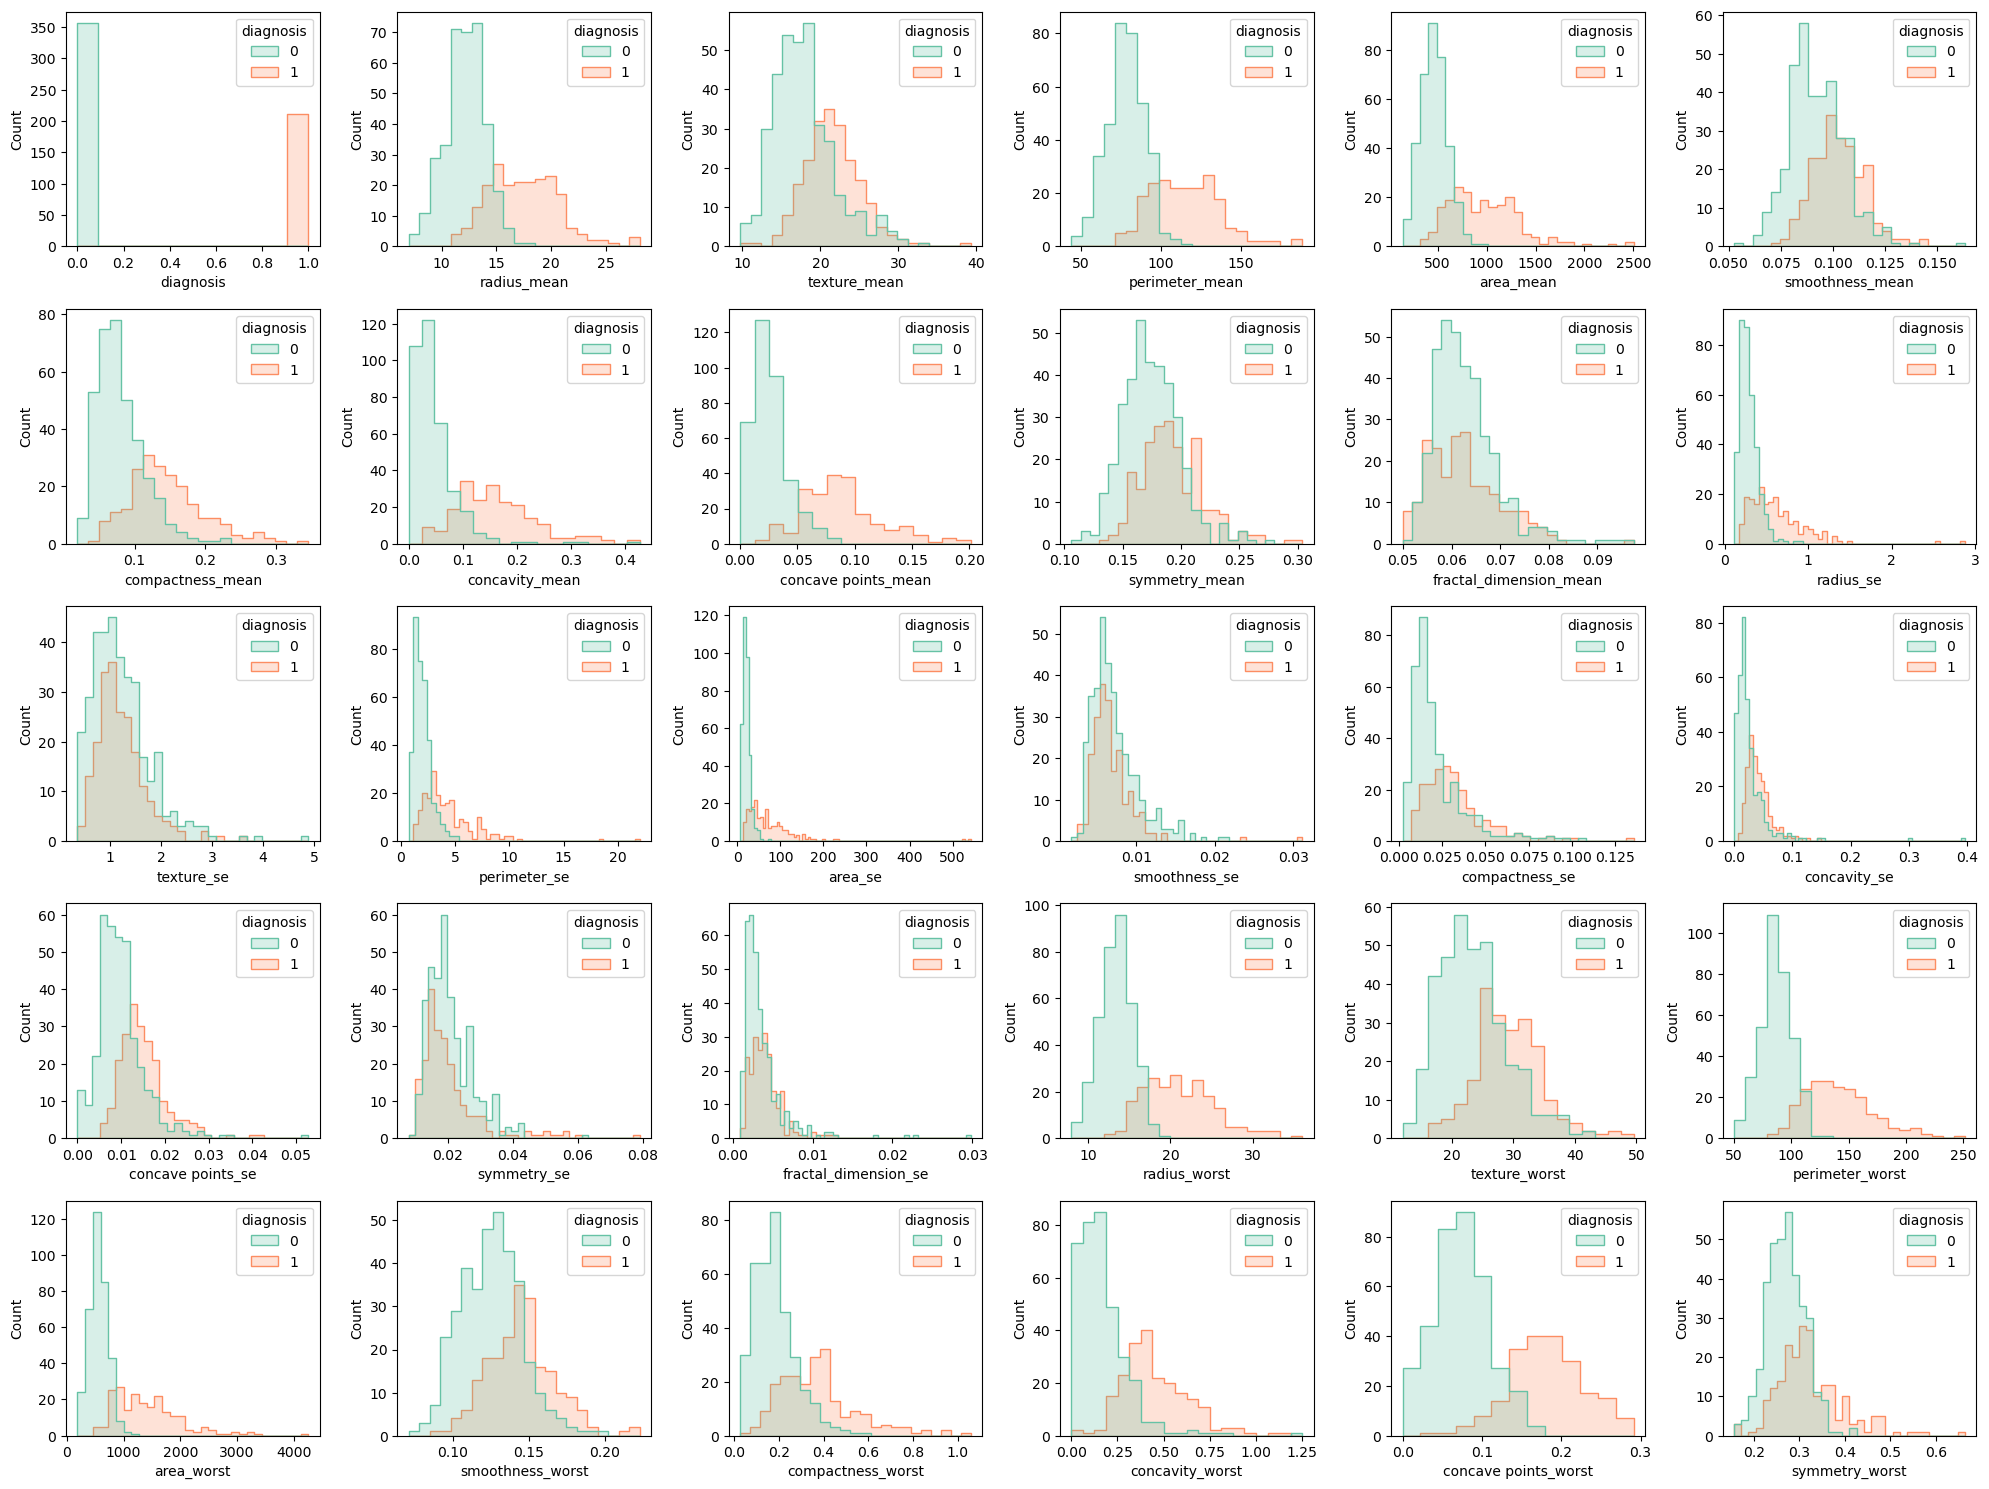

In [52]:
plt.figure(figsize = (20, 15))
plotnumber = 1
for i in col:
    if plotnumber <= 30:
        ax = plt.subplot(5, 6, plotnumber)
        sns.histplot(data=df, x=i,hue=df['diagnosis'], multiple="layer", element="step", palette="Set2")
        plt.xlabel(i)
    plotnumber += 1
plt.tight_layout()
plt.show()    

In [54]:
skewness = df.skew()
sque=[]
# the skewness for each column
for col in df.columns:
    s=skewness[col]
    sque.append(s)
sque.sort()    
print(sque)

[0.4154259962824678, 0.45632376481955844, 0.49261552688550875, 0.49832130948716474, 0.5284613207977967, 0.6504495420828159, 0.7256089733641999, 0.9423795716730992, 0.9906504253930081, 1.1031152059604372, 1.1281638713683722, 1.1502368219460262, 1.1711800812336282, 1.1901230311980404, 1.3044888125755076, 1.4011797389486722, 1.433927765189328, 1.4446781446974786, 1.4735549003297956, 1.6457321756240424, 1.646443808753053, 1.6625792663955146, 1.8593732724433467, 1.9022207096378565, 2.1951328995478216, 2.314450056636759, 3.0886121663847574, 3.443615202194899, 3.923968620227413, 5.110463049043661, 5.447186284898394]


In [57]:
import scipy.stats as stats
k = stats.kurtosis(df, fisher=False)
l=[]
for i in k:
    i=round(i,2)
    l.append(i)
print(f"Kurtosis: {l}")
k.sort()

Kurtosis: [1.28, 3.83, 3.74, 3.95, 6.61, 3.84, 4.63, 4.97, 4.05, 4.27, 5.97, 20.52, 8.29, 24.2, 51.77, 13.37, 8.05, 51.42, 8.07, 10.82, 29.04, 3.93, 3.21, 4.05, 7.35, 3.5, 6.0, 4.59, 2.46, 7.4, 8.19]


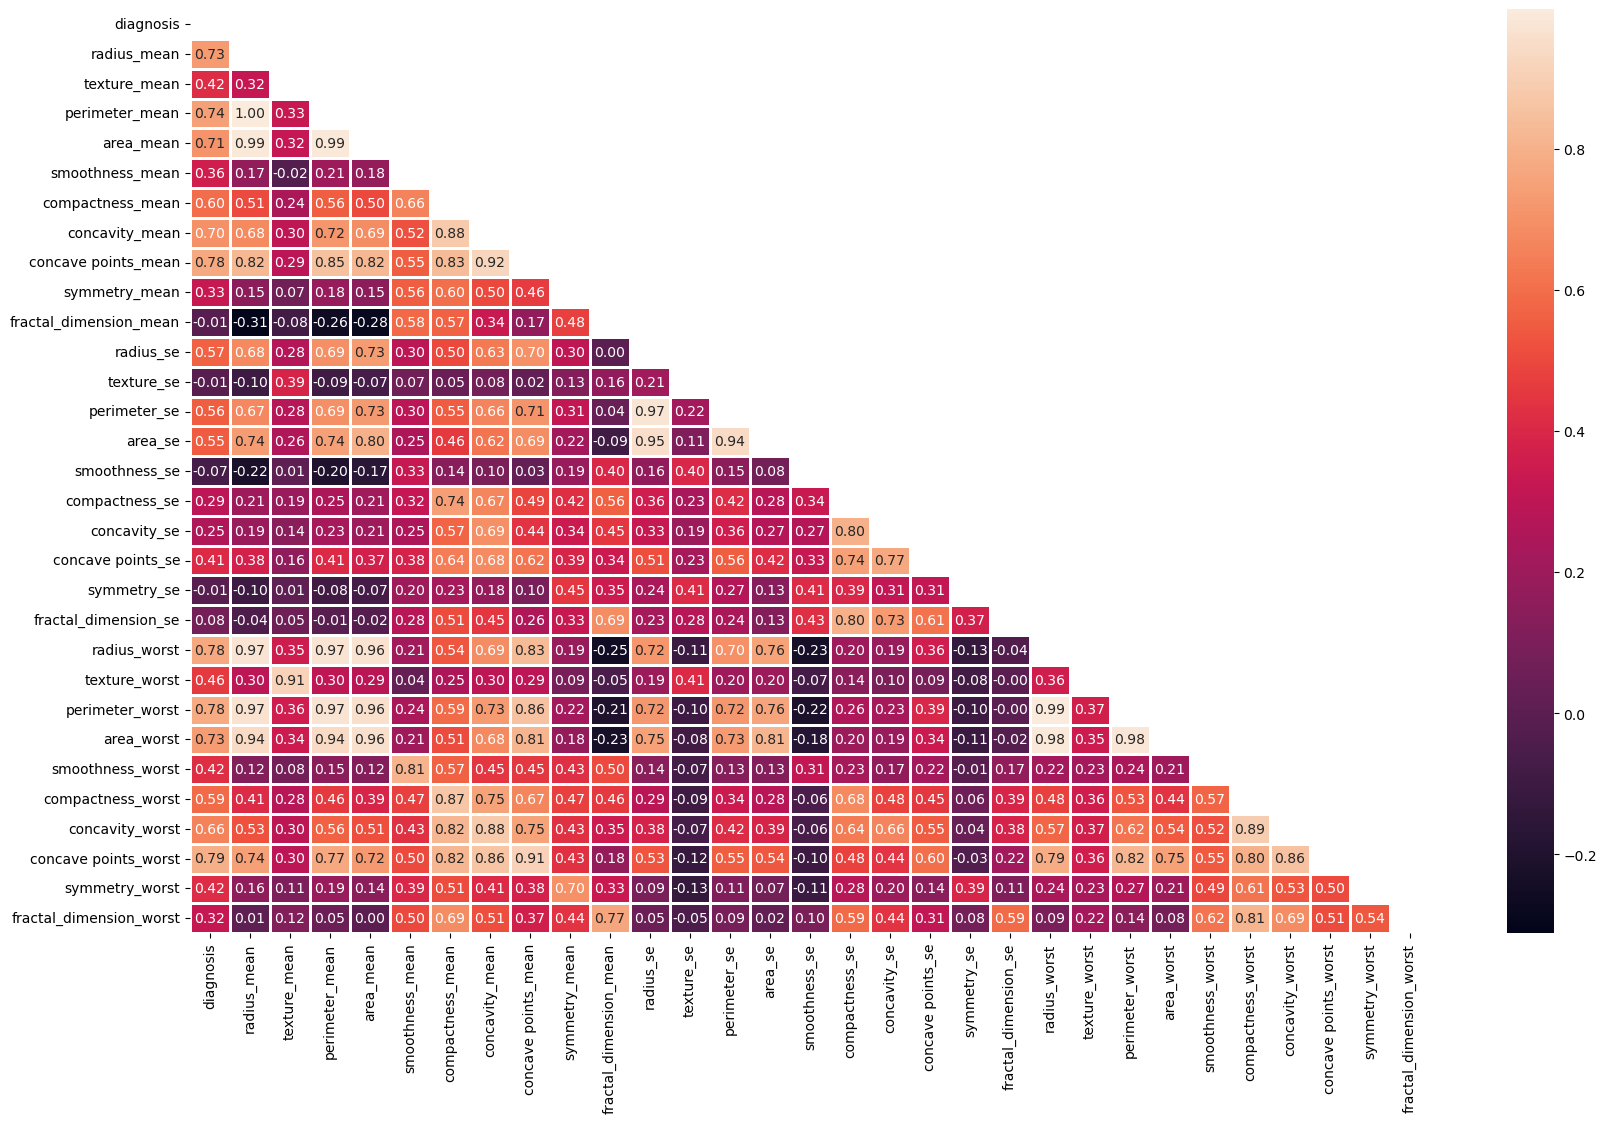

In [59]:
# heatmap 
plt.figure(figsize = (20, 12))
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype = bool))
sns.heatmap(corr, mask = mask, linewidths = 1, annot = True, fmt = ".2f")
plt.show()

We can see that there are many columns which are very highly correlated which causes multicollinearity so we need to handle highly correlated features.  

code preprocesses data by oversampling with SMOTE, selects top 5 features using mutual information, and displays the resulting DataFrame.

In [60]:
target_column = 'diagnosis'
X_train, X_test, y_train, y_test = train_test_split(df.drop(target_column, axis=1), df[target_column], test_size=0.2, random_state=42)
# Apply SMOTE for oversampling
X_train_resampled, y_train_resampled = SMOTE(random_state=42).fit_resample(X_train, y_train)
# Select the top k features using SelectKBest and mutual information
k_best = 5
selector = SelectKBest(mutual_info_classif, k=k_best)
X_train_resampled_kbest = selector.fit_transform(X_train_resampled, y_train_resampled)
X_test_kbest = selector.transform(X_test)
# Create a DataFrame with the top features and the target variable
df_top_features_resampled = pd.DataFrame(X_train_resampled_kbest, columns=X_train.columns[selector.get_support()])
df_top_features_resampled[target_column] = y_train_resampled
# Display the DataFrame with top features after SMOTE
print("DataFrame with Top Features after SMOTE:")
df_top_features_resampled.head()

DataFrame with Top Features after SMOTE:


,concave points_mean,radius_worst,perimeter_worst,area_worst,concave points_worst,diagnosis
0,0.04375,10.31,65.50,324.7,0.17500,0
1,0.14960,26.68,176.50,2089.0,0.29030,1
2,0.02180,10.01,65.59,310.1,0.05087,0
3,0.01615,12.25,77.98,455.7,0.06136,0
4,0.01290,11.02,69.86,368.6,0.02579,0


In [61]:
df_top_features_resampled.describe()

,concave points_mean,radius_worst,perimeter_worst,area_worst,concave points_worst,diagnosis
count,572.000000,572.000000,572.000000,572.000000,572.000000,572.000000
mean,0.055720,17.203659,113.912464,981.456536,0.126684,0.500000
std,0.039162,5.003364,34.739223,593.962701,0.065551,0.500438
min,0.000000,8.678000,54.490000,223.600000,0.000000,0.000000
25%,0.023288,13.347500,86.790000,547.400000,0.072740,0.000000
50%,0.048770,16.113372,105.900000,790.850000,0.124953,0.500000
75%,0.084711,20.583628,138.225000,1295.782242,0.176731,1.000000
max,0.201200,36.040000,251.200000,4254.000000,0.291000,1.000000


In [62]:
df=df_top_features_resampled.copy()

In [63]:
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

In [64]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Function to replace outliers with the median in a DataFrame
def replace_outliers_with_median(dataframe, threshold=3):
    for column in dataframe.columns:
        z_scores = np.abs(stats.zscore(dataframe[column]))
        outliers = dataframe[column][z_scores > threshold]
        median = dataframe[column].median()
        dataframe[column][outliers.index] = median
    return dataframe
z_score_threshold = 3
# Replace outliers with median in the training data
X_train_no_outliers = replace_outliers_with_median(X_train, threshold=z_score_threshold)


In [65]:
# scaling data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


---
# K Neighbors Classifier (KNN)
---

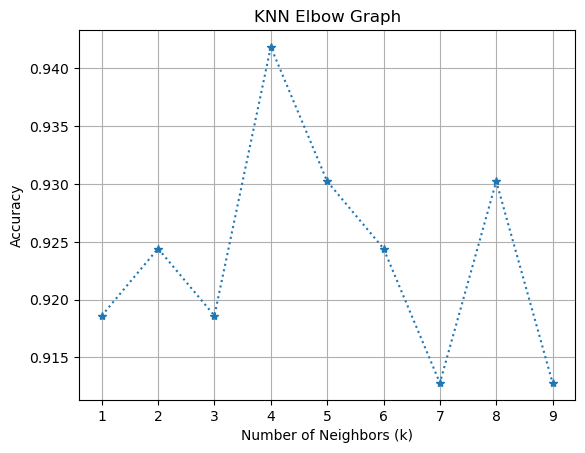

In [66]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Range of k values to test
k_values = range(1, 10)
# Calculate accuracy scores for different k values and plot the elbow graph
plt.plot(k_values, [accuracy_score(y_test, KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train).predict(X_test)) for k in k_values], marker='*', linestyle=':')
plt.title("KNN Elbow Graph")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

#### Hyperparameter tuning

In [74]:
# Perform hyperparameter tuning for KNN
grid_search = GridSearchCV(KNeighborsClassifier(), {'n_neighbors': range(1, 10)}, cv=5, scoring='accuracy').fit(X_train, y_train)
# Train the final model with the best hyperparameters
final_model = KNeighborsClassifier(n_neighbors=grid_search.best_params_['n_neighbors']).fit(X_train, y_train)
# Evaluate the final model on the test set
y_pred = final_model.predict(X_test)
# Display the results
print(f"Best k value: {grid_search.best_params_['n_neighbors']}")
print(f"Accuracy on test set with best k: {accuracy_score(y_test, y_pred):.2f}")
# Display the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
knn_rec = recall_score(y_test, y_pred)


Best k value: 3
Accuracy on test set with best k: 0.92

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92        86
           1       0.91      0.93      0.92        86

    accuracy                           0.92       172
   macro avg       0.92      0.92      0.92       172
weighted avg       0.92      0.92      0.92       172



---
# Decision Tree Classifier
---

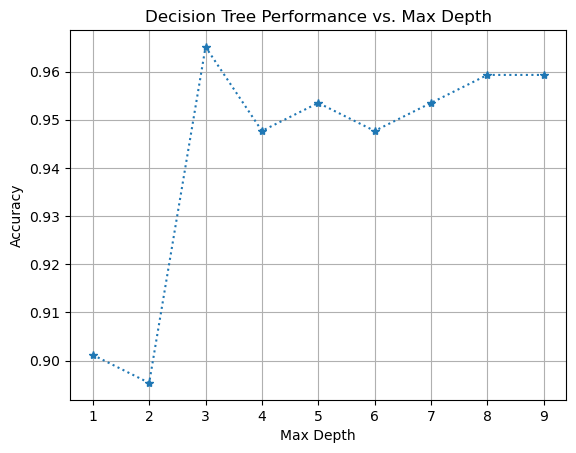

In [76]:
# Range of max_depth values to test
max_depths = range(1, 10)
# Calculate accuracy scores for different max_depth values and plot the graph
plt.plot(max_depths, [DecisionTreeClassifier(max_depth=depth, random_state=42).fit(X_train, y_train).score(X_test, y_test) for depth in max_depths], marker='*', linestyle=':')
plt.title("Decision Tree Performance vs. Max Depth")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

#### Hyperparameter tuning

In [78]:
# Perform hyperparameter tuning for Decision Tree
grid_search_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), {'max_depth': range(1, 10)}, cv=5, scoring='accuracy').fit(X_train, y_train)
# Train the final Decision Tree model with the best hyperparameters
final_model_dt = DecisionTreeClassifier(max_depth=grid_search_dt.best_params_['max_depth'], random_state=42).fit(X_train, y_train)
# Evaluate the final Decision Tree model on the test set
y_pred_dt = final_model_dt.predict(X_test)
# Display the results for Decision Tree
print(f"Best max_depth value: {grid_search_dt.best_params_['max_depth']}")
print(f"Accuracy on test set with best max_depth: {accuracy_score(y_test, y_pred_dt):.2f}")
# Display the classification report for Decision Tree
print("\nClassification Report (Decision Tree):")
print(classification_report(y_test, y_pred_dt))
# Store recall value for Decision Tree
dt_rec = recall_score(y_test, y_pred_dt)
print(f"Recall on test set with best max_depth: {dt_rec:.2f}")

Best max_depth value: 3
Accuracy on test set with best max_depth: 0.97

Classification Report (Decision Tree):
              precision    recall  f1-score   support

           0       0.98      0.95      0.96        86
           1       0.95      0.98      0.97        86

    accuracy                           0.97       172
   macro avg       0.97      0.97      0.97       172
weighted avg       0.97      0.97      0.97       172

Recall on test set with best max_depth: 0.98


---
# Random Forest Classifier
---

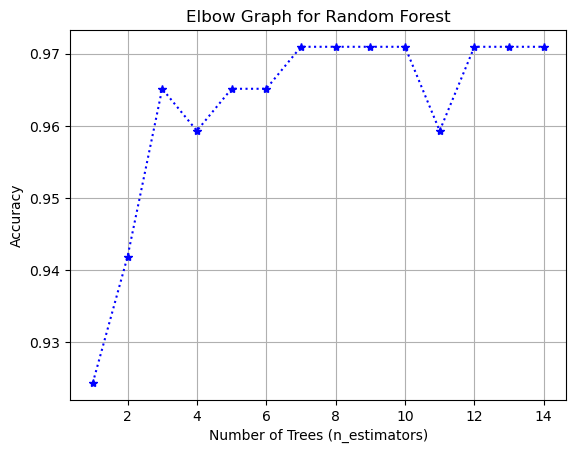

In [80]:
# Define a range of n_estimators
n_estimators_range = range(1, 15)  
# Create an elbow plot to visualize the relationship between n_estimators and accuracy
plt.plot(n_estimators_range, [RandomForestClassifier(n_estimators=n, random_state=42).fit(X_train, y_train).score(X_test, y_test) for n in n_estimators_range], marker='*', linestyle=':', color='b')
plt.title("Elbow Graph for Random Forest")
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


#### Hyperparameter tuning

In [82]:
# Perform hyperparameter tuning for Random Forest
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), {'n_estimators': range(1, 15)}, cv=5, scoring='accuracy').fit(X_train, y_train)
# Train the final Random Forest model with the best hyperparameters
final_model_rf = RandomForestClassifier(n_estimators=grid_search_rf.best_params_['n_estimators'], random_state=42).fit(X_train, y_train)
# Evaluate the final Random Forest model on the test set
y_pred_rf = final_model_rf.predict(X_test)
# Display the results for Random Forest
print(f"Best n_estimators value: {grid_search_rf.best_params_['n_estimators']}")
print(f"Accuracy on test set with best n_estimators: {accuracy_score(y_test, y_pred_rf):.2f}")
# Display the classification report for Random Forest
print("\nClassification Report (Random Forest):")
print(classification_report(y_test, y_pred_rf))
# Store recall value for Random Forest
rec_rec = recall_score(y_test, y_pred_rf)
print(f"Recall on test set with best n_estimators: {rec_rec:.2f}")

Best n_estimators value: 9
Accuracy on test set with best n_estimators: 0.97

Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.99      0.95      0.97        86
           1       0.96      0.99      0.97        86

    accuracy                           0.97       172
   macro avg       0.97      0.97      0.97       172
weighted avg       0.97      0.97      0.97       172

Recall on test set with best n_estimators: 0.99


---
# Logistic Regression
---

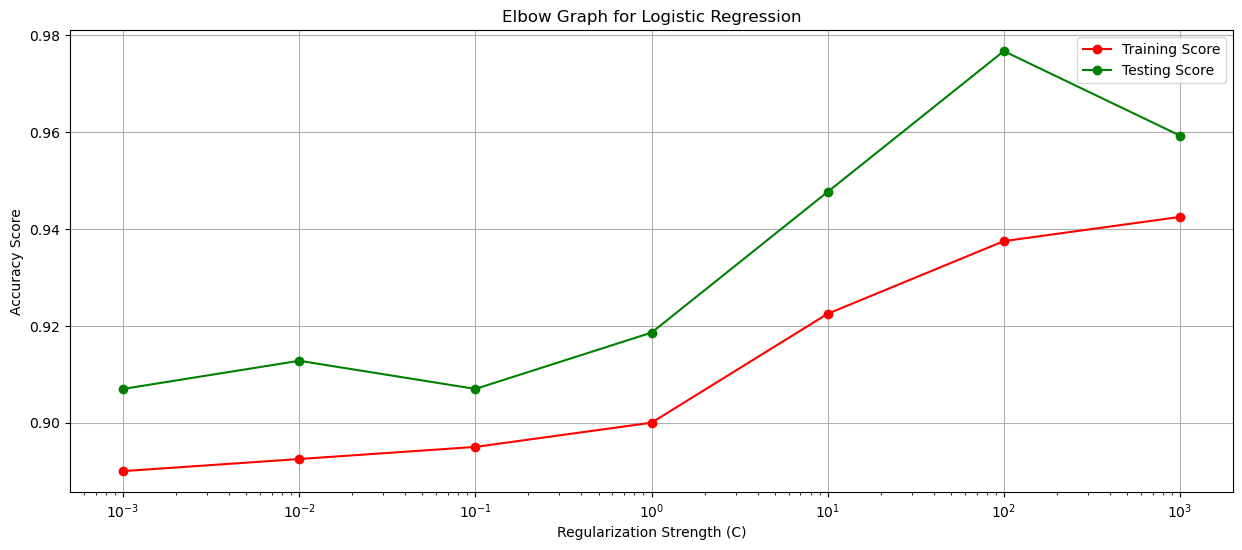

In [83]:
from sklearn.linear_model import LogisticRegression
# Define a range of regularization strengths (C values)
C_values = np.logspace(-3, 3, 7)  
# Use list comprehensions to calculate scores
train_scores_lr = [LogisticRegression(C=C, random_state=42).fit(X_train, y_train).score(X_train, y_train) for C in C_values]
test_scores_lr = [LogisticRegression(C=C, random_state=42).fit(X_train, y_train).score(X_test, y_test) for C in C_values]
# Create an elbow graph to visualize the scores for Logistic Regression
plt.figure(figsize=(15, 6))
plt.plot(C_values, train_scores_lr, marker='o', label='Training Score', color='red')
plt.plot(C_values, test_scores_lr, marker='o', label='Testing Score', color='green')
plt.xscale('log')
plt.title('Elbow Graph for Logistic Regression')
plt.xlabel('Regularization Strength (C)')
plt.ylabel('Accuracy Score')
plt.legend()
plt.grid()
plt.show()


#### Hyper parameter tuning

In [84]:
# Perform hyperparameter tuning for Logistic Regression
grid_search_lr = GridSearchCV(LogisticRegression(random_state=42), {'C': np.logspace(-3, 3, 7)}, cv=5, scoring='accuracy').fit(X_train, y_train)
# Train the final Logistic Regression model with the best hyperparameters
final_model_lr = LogisticRegression(C=grid_search_lr.best_params_['C'], random_state=42).fit(X_train, y_train)
# Evaluate the final Logistic Regression model on the test set
y_pred_lr = final_model_lr.predict(X_test)
# Display the results for Logistic Regression
print(f"Best C value: {grid_search_lr.best_params_['C']}")
print(f"Accuracy on test set with best C: {accuracy_score(y_test, y_pred_lr):.2f}")
# Display the classification report for Logistic Regression
print("\nClassification Report (Logistic Regression):")
print(classification_report(y_test, y_pred_lr))
# Store recall value for Logistic Regression
rec_lr = recall_score(y_test, y_pred_lr)
print(f"Recall on test set with best C: {rec_lr:.2f}")


Best C value: 1000.0
Accuracy on test set with best C: 0.96

Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.98      0.94      0.96        86
           1       0.94      0.98      0.96        86

    accuracy                           0.96       172
   macro avg       0.96      0.96      0.96       172
weighted avg       0.96      0.96      0.96       172

Recall on test set with best C: 0.98


---
# Extreme Gradient Boosting
---

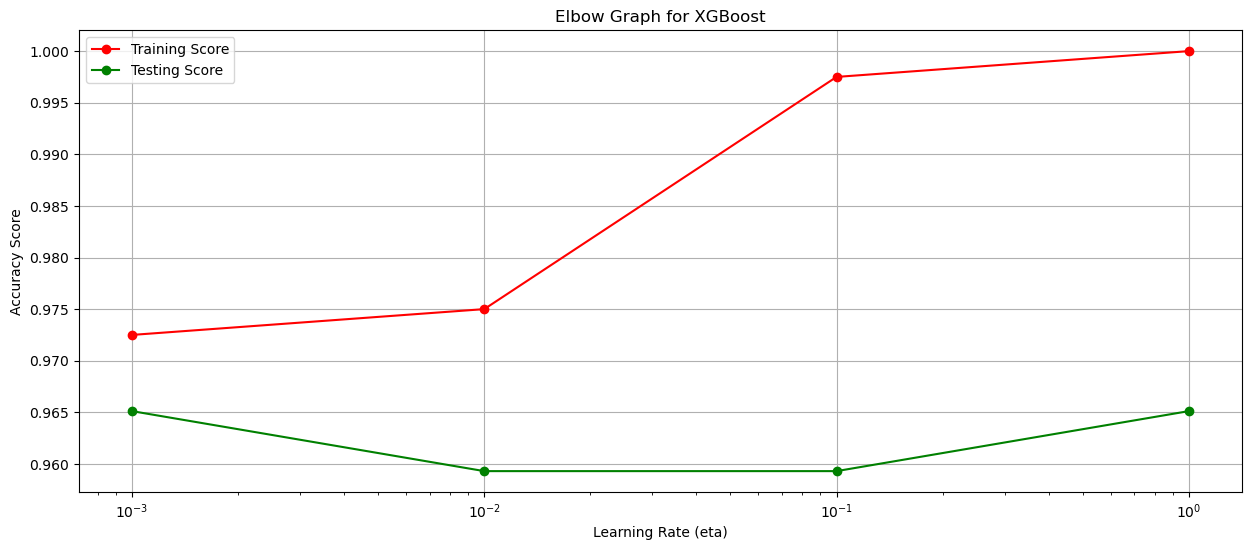

In [85]:
# Define a range of learning rates (eta values)
eta_values = np.logspace(-3, 0, 4)
# Use list comprehensions to calculate scores
train_scores_xgb = [XGBClassifier(eta=eta, random_state=42).fit(X_train, y_train).score(X_train, y_train) for eta in eta_values]
test_scores_xgb = [XGBClassifier(eta=eta, random_state=42).fit(X_train, y_train).score(X_test, y_test) for eta in eta_values]
# Create an elbow graph to visualize the scores for XGBoost
plt.figure(figsize=(15, 6))
plt.plot(eta_values, train_scores_xgb, marker='o', label='Training Score', color='red')
plt.plot(eta_values, test_scores_xgb, marker='o', label='Testing Score', color='green')
plt.xscale('log')
plt.title('Elbow Graph for XGBoost')
plt.xlabel('Learning Rate (eta)')
plt.ylabel('Accuracy Score')
plt.legend()
plt.grid()
plt.show()


#### Hyper parameter tuning

In [86]:
# Perform hyperparameter tuning for XGBoost
grid_search_xgb = GridSearchCV(XGBClassifier(random_state=42), {'eta': np.logspace(-3, 0, 4)}, cv=5, scoring='accuracy').fit(X_train, y_train)
# Train the final XGBoost model with the best hyperparameters
final_model_xgb = XGBClassifier(eta=grid_search_xgb.best_params_['eta'], random_state=42).fit(X_train, y_train)
# Evaluate the final XGBoost model on the test set
y_pred_xgb = final_model_xgb.predict(X_test)
# Display the results for XGBoost
print(f"Best eta value: {grid_search_xgb.best_params_['eta']}")
print(f"Accuracy on test set with best eta: {accuracy_score(y_test, y_pred_xgb):.2f}")
# Display the classification report for XGBoost
print("\nClassification Report (XGBoost):")
print(classification_report(y_test, y_pred_xgb))
# Store recall value for XGBoost
rec_xgb = recall_score(y_test, y_pred_xgb)
print(f"Recall on test set with best eta: {rec_xgb:.2f}")

Best eta value: 1.0
Accuracy on test set with best eta: 0.97

Classification Report (XGBoost):
              precision    recall  f1-score   support

           0       0.99      0.94      0.96        86
           1       0.94      0.99      0.97        86

    accuracy                           0.97       172
   macro avg       0.97      0.97      0.97       172
weighted avg       0.97      0.97      0.97       172

Recall on test set with best eta: 0.99


---
# Model Scorecard
---

In [91]:
# Define models
models = {
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree Classifier': DecisionTreeClassifier(random_state=42),
    'Random Forest Classifier': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'XgBoost': XGBClassifier(random_state=42)
}
# Evaluate and calculate AIC for each model
model_results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    recall = recall_score(y_test, y_pred) * 100
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    num_params = len(model.coef_[0]) + 1 if hasattr(model, 'coef_') else 1
    aic = 2 * log_loss(y_test, y_pred_proba, normalize=False) + 2 * num_params
    model_results.append({'Model': name, 'AIC': aic, 'Recall': recall})
# Create a DataFrame with model results
models_df = pd.DataFrame(model_results)
# Sort the DataFrame by AIC in ascending order
models_sorted_by_aic = models_df.sort_values(by='AIC')
# Display the sorted DataFrame
print(models_sorted_by_aic)

                      Model         AIC     Recall
2  Random Forest Classifier   16.951380  98.245614
4                   XgBoost   18.885327  98.245614
3       Logistic Regression   50.297914  89.473684
0                       KNN  244.537002  94.736842
1  Decision Tree Classifier  362.436534  98.245614


# Random Forst gives the best performance
- Random Forest excels due to ensemble learning, reduced variance, feature importance, robustness to overfitting, non-linear pattern capture, missing value handling, simplicity, scalability, and effective noise reduction.